In [1]:
import numpy as np

In [300]:
class FCLayer():
    def __init__(self, input_size, output_size, lr=0.001):
        # Initialize weights with Xavier
        self.lr = lr
        init_bound = np.sqrt(6)/(np.sqrt(input_size+output_size))
        self.weights = np.random.uniform(-1.0,1.0,size=(input_size,output_size))*init_bound
        
        self.bias = np.zeros(output_size)
        
    def forward(self, x):
        self.x = x
        return np.matmul(x, self.weights) + self.bias
    
    def backward(self,grad):
        # we have dl/dz coming in, need dl/dw = dl/dz*dz/dw
        
        # Can be shown: dL/dx = dL/dz W^T and dL/dw = X^T dL/dz
        dldx = grad.dot(self.weights.T)
        dldw = self.x.T.dot(grad)
        
        self.weights = self.weights - self.lr*dldw
        self.bias = self.bias - self.lr*np.sum(grad, axis = 0)
        
        return dldx

    
# Don't actually need this, better to compute the sigmoid as part of the BCE loss so that we can skip the back prop
class Sigmoid():
    def __init__(self):
        pass
    
    def forward(self,x):
        self.sigma = 1/(1+np.exp(x))
        return self.sigma
    
    def backward(self,grad):
        return grad.dot(self.sigma(1.0 - self.sigma))
    
    
class ReLu():
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        return np.maximum(0,x)
    
    def backward(self, grad):
        relu_grad = self.x>0
        return grad*relu_grad

    
    
    
class Cross_Entropy_With_Logits():
    def __init__(self):
        pass
    
    def forward(self, logits, classes):
        '''
        Classes here are the class labels, not one hot encoded
        Logit takes the form [num_batches, num_classes]
        '''
        # For numerical stability
        logits -= np.max(logits, axis = 1, keepdims=True)
        
        self.logits = logits
        self.classes = classes
        
        # Get the correct activation:
        logit_correct = logits[range(len(logits)),classes]
        
        # Cross entropy is defined as \sum{i}{N}y_i*log(p_i)
        # if we write log(p_i) = log(exp(a_correct)/sum{i}{N}exp(a_i))
        # H = -exp(a_correct) + log(sum(exp(a)))
        
        return (-logit_correct + np.log(np.sum(np.exp(logits),axis=-1)))/self.logits.shape[0]
    
    def backward(self):
        # The backprop is p_i - y_i, where y_i is one hot encoded
        
        # Encode the class
        class_ones = np.zeros_like(self.logits)
        class_ones[range(len(self.logits)),self.classes] = 1
        
        prob = np.exp(self.logits) / np.exp(self.logits).sum(axis=-1,keepdims=True)
        
        # Don't be stupid, normalize the loss over batches
        return (prob - class_ones)/self.logits.shape[0]

In [274]:
dense1 = FCLayer(10,100)

In [239]:
z = dense1.forward(b)
z.shape

(100, 100)

In [143]:
activation1 = ReLu()
a = activation1.forward(z)
a.shape

(100, 100)

In [144]:
CE = Cross_Entropy_With_Logits()

In [145]:
y = np.random.randint(0,99,size = (100,100))

In [146]:
loss = CE.forward(a, y)

In [147]:
g = CE.backward()

In [148]:
relu_g = activation1.backward(g)

In [149]:
relu_g.shape

(100, 100)

In [150]:
dense_g = dense1.backward(relu_g)

In [155]:
import keras
import matplotlib.pyplot as plt

In [156]:
def load_dataset(flatten=True):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test
  
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [167]:
def softmax(x):
    prob = np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)
    return prob

In [212]:
def forward(network, x):
    X = x
    for i in network:
        X = i.forward(X)
    return X

In [213]:
def backward(network, logits, y):
    CE = Cross_Entropy_With_Logits()
    loss = CE.forward(logits, y)
    loss_grad = CE.backward()
    
    for i in network[::-1]:
        loss_grad = i.backward(loss_grad)
    
    return np.mean(loss)

In [214]:
def train(network, x, y):
    logits = forward(network, x)
    loss = backward(network, logits, y)
    
    train_acc = np.mean(logits.argmax(axis=-1)==y)
    
    return loss, train_acc

In [215]:
def predict(network,x):
    logits = forward(network,x)
    return logits.argmax(axis=-1)

In [262]:
def minibatch(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(x))
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [297]:
# Make network
lr = 0.01
network = []
network.append(FCLayer(X_train[0].shape[0], 100,lr=lr))
network.append(ReLu())
network.append(FCLayer(100, 200, lr=lr))
network.append(ReLu())
network.append(FCLayer(200, 10, lr=lr)) # outputs logits

In [291]:
# training loop
train_loss = []
train_acc = []
val_acc = []

for epoch in range(25):
    loss, acc = train(network, X_train, y_train)
    train_loss.append(loss)
    train_acc.append(acc)
    
    val_acc.append(np.mean(predict(network, X_val)==y_val))
    
    

In [292]:
train_loss

[2.308701753690995,
 2.2467176676790723,
 2.1942440531203173,
 2.145856874375494,
 2.099078196739294,
 2.0524869176623683,
 2.0053347944696727,
 1.9572191938362085,
 1.9079884324638303,
 1.8576441713954595,
 1.8062449291292975,
 1.753921561228633,
 1.7007838978754546,
 1.647055783184673,
 1.5929655831755303,
 1.538819051107034,
 1.484947747466322,
 1.4317504712046287,
 1.3796046445159926,
 1.3288652410970727,
 1.279838780643565,
 1.2328005582974886,
 1.1879387659779943,
 1.145386060927559,
 1.1052017646678265]

In [293]:
train_acc

[0.1368,
 0.2015,
 0.27414,
 0.34362,
 0.409,
 0.46446,
 0.51232,
 0.55198,
 0.5847,
 0.61096,
 0.63482,
 0.65338,
 0.66932,
 0.68316,
 0.69606,
 0.70616,
 0.71518,
 0.72416,
 0.73154,
 0.73864,
 0.74544,
 0.75224,
 0.7585,
 0.7644,
 0.77006]

In [294]:
val_acc

[0.2039,
 0.2774,
 0.349,
 0.4143,
 0.4719,
 0.5235,
 0.5663,
 0.6019,
 0.6313,
 0.654,
 0.6729,
 0.688,
 0.7037,
 0.7188,
 0.7298,
 0.7415,
 0.7496,
 0.7571,
 0.7644,
 0.7716,
 0.7792,
 0.7855,
 0.792,
 0.7966,
 0.8021]

In [298]:
# training loop
train_loss = []
train_acc = []
val_acc = []

for epoch in range(35):
    loss_temp = []
    acc_temp = []
    for x, y in minibatch(X_train, y_train, 32):
        loss, acc = train(network, x, y)
        loss_temp.append(loss)
        acc_temp.append(acc)
    train_loss.append(np.mean(loss_temp))
    train_acc.append(np.mean(acc_temp))
    
    val_acc.append(np.mean(predict(network, X_val)==y_val))
    
    

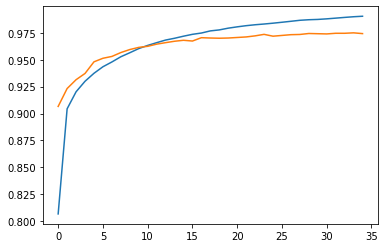

In [299]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()